In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

# Preprocessing

In [3]:
#------------
# nn = number of nodes
# ne = number of elements
# nmat = number of materials used
# p_type = problem type
# nlbc = number of load bounder conditions
# ndbc = number of displacement boundary conditions
# t = thickness
# dofpn = degree of freedom per node
# nnpe = number of nodes per element
# tdof = total degree of freedom
#------------

nn,ne,nmat,p_type,nlbc,ndbc=np.loadtxt('P.txt').astype(np.int32)
t=0.5
dofpn=2
nnpe=3
tdof=nn*dofpn

Convertion of Physical Problem into FEM Quantities

In [4]:
coord=np.loadtxt('coord.txt').astype(np.float32)

In [5]:
nca=np.loadtxt('nca.txt').astype(np.int32)

In [6]:
mat=np.loadtxt('mat.txt').astype(np.float32)

In [7]:
load_bc=np.loadtxt('load_bc.txt').astype(np.float32)

In [8]:
disp_bc=np.loadtxt('disp_bc.txt').astype(np.float32)

# Verification

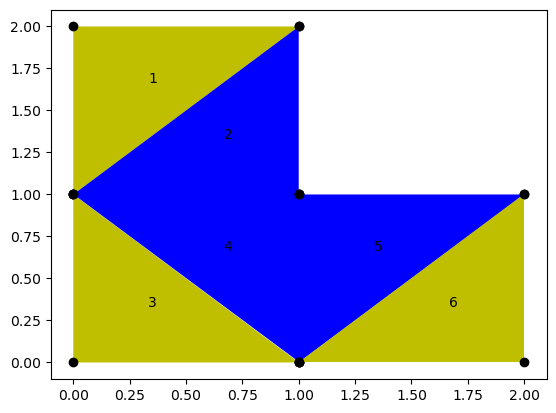

In [9]:
for elem in range(1,ne+1,1):
    
    #----Extraction of Nodes-----
    
    N1=nca[elem,1]
    N2=nca[elem,2]
    N3=nca[elem,3]
    
    #----Extraction of Nodal Co-ordinates----
    
    X1N1=coord[N1,1]
    X2N1=coord[N1,2]
    X1N2=coord[N2,1]
    X2N2=coord[N2,2]
    X1N3=coord[N3,1]
    X2N3=coord[N3,2]
    
    #-----Extraction of Material Type of Element----
    
    Mat_num=nca[elem,4]
    
    #-----Plotting the model of given problem----
    
    X=[X1N1,X1N2,X1N3]
    Y=[X2N1,X2N2,X2N3]
    CGX=(X1N1+X1N2+X1N3)/3
    CGY=(X2N1+X2N2+X2N3)/3
    if Mat_num==1:
        plt.fill(X,Y,'y')
    else:
        plt.fill(X,Y,'b')
    plt.scatter(X,Y,c='black')
    plt.text(CGX,CGY,str(elem))

# Solution

In [10]:
#---Initialization------
# GSTIFF = Global Stiffness Matrix
# F = Global Force Vector
#-------------------------

GSTIFF=np.zeros((tdof,tdof))
F=np.zeros(tdof)

In [11]:
#--------Construction of Global Stiffness Matrix--------

for elem in range(1,ne+1,1):
    
    #----Extraction of Nodes-----
    
    N1=nca[elem,1]
    N2=nca[elem,2]
    N3=nca[elem,3]
    
    #----Extraction of Nodal Co-ordinates----
    
    X1N1=coord[N1,1]
    X2N1=coord[N1,2]
    X1N2=coord[N2,1]
    X2N2=coord[N2,2]
    X1N3=coord[N3,1]
    X2N3=coord[N3,2]
    
    #-------Construction of B Matrix-----
    
    two_delta=np.linalg.det(np.array([[1,X1N1,X2N1],[1,X1N2,X2N2],[1,X1N3,X2N3]]))
    B1=X2N2-X2N3
    B2=X2N3-X2N1
    B3=X2N1-X2N2
    G1=X1N3-X1N2
    G2=X1N1-X1N3
    G3=X1N2-X1N1
    B=np.zeros((3,6))
    B[0,0]=B1
    B[0,2]=B2
    B[0,4]=B3
    B[1,1]=G1
    B[1,3]=G2
    B[1,5]=G3
    B[2,0]=G1
    B[2,1]=B1
    B[2,2]=G2
    B[2,3]=B2
    B[2,4]=G3
    B[2,5]=B3
    B=B/two_delta
    
    #---Construction of D Matrix------
    
    mat_num=nca[elem,4]
    E=mat[mat_num,1]
    PR=mat[mat_num,2]
    CONST=E/(1-PR**2)
    D=np.zeros((3,3))
    D[0,0]=1
    D[0,1]=PR
    D[0,2]=0
    D[1,0]=PR
    D[1,1]=1
    D[1,2]=0
    D[2,0]=0
    D[2,1]=0
    D[2,2]=(1-PR)/2
    D=D*CONST
    
    #-----Construction of Element Stiffness Matrix--------
    
    ESTIFF=B.transpose()@D@B*t*two_delta*0.5
    
    #-----Construction of Global Stiffness Matrix------
    
    CN=[2*N1-2,2*N1-1,2*N2-2,2*N2-1,2*N3-2,2*N3-1]
    CN_IDX=np.array(6*CN).reshape(6,6)
    RN_IDX=CN_IDX.transpose()
    GSTIFF[RN_IDX,CN_IDX]=GSTIFF[RN_IDX,CN_IDX]+ESTIFF

In [12]:
#-------Construction of Global Force Vector-----

for i in range (1,nlbc+1,1):
    load_type=load_bc[i,2]
    if load_type==1:
        N=int(load_bc[i,1])
        F[(2*N-2)]=F[(2*N-2)]+load_bc[i,3]
    elif load_type==2:
        N=int(load_bc[i,1])
        F[(2*N-1)]=F[(2*N-1)]+load_bc[i,4]
    else:
        N=int(load_bc[i,1])
        F[(2*N-2)]=F[(2*N-2)]+load_bc[i,3]
        F[(2*N-1)]=F[(2*N-1)]+load_bc[i,4]

In [13]:
GSTIFFCOPY=GSTIFF.copy()

In [14]:
#---Modifying Global Stiffness Matrix using Penalty Method------

for i in range (1,ndbc+1,1):
    disp_type=disp_bc[i,2]
    if disp_type==1:
        N=int(disp_bc[i,1])
        F[(2*N-2)]=F[(2*N-2)]+(disp_bc[i,3]*10**16)
        GSTIFFCOPY[2*N-2,2*N-2]=GSTIFFCOPY[2*N-2,2*N-2]+10**16
    elif disp_type==2:
        N=int(disp_bc[i,1])
        F[(2*N-1)]=F[(2*N-1)]+(disp_bc[i,4]*10**16)
        GSTIFFCOPY[2*N-1,2*N-1]=GSTIFFCOPY[2*N-1,2*N-1]+10**16
    else:
        N=int(disp_bc[i,1])
        F[(2*N-2)]=F[(2*N-2)]+(disp_bc[i,3]*10**16)
        GSTIFFCOPY[2*N-2,2*N-2]=GSTIFFCOPY[2*N-2,2*N-2]+10**16
        F[(2*N-1)]=F[(2*N-1)]+(disp_bc[i,4]*10**16)
        GSTIFFCOPY[2*N-1,2*N-1]=GSTIFFCOPY[2*N-1,2*N-1]+10**16

In [15]:
#-----Solving [K][u]=[F]------

DISP=np.linalg.solve(GSTIFFCOPY,F)
print(DISP.reshape(-1,2))

[[-7.27519248e-14  1.50000000e-13]
 [ 7.27519248e-14 -3.00000000e-13]
 [-2.56521146e-08  1.85395430e-08]
 [-3.17626208e-08 -3.17493009e-08]
 [-2.81564306e-08 -1.54938479e-07]
 [-1.10945515e-07  2.58361595e-08]
 [-1.18242131e-07 -3.75673908e-08]
 [-1.27299209e-07 -1.57881402e-07]]


# Post Processing

In [16]:
#-----Initialization------

strain=np.empty(shape=(3,0))
stress=np.empty(shape=(3,0))

In [20]:
#----Calculation of Stress and Strain------

for elem in range(1,ne+1,1):
    
    #----Extraction of Nodes-----
    
    N1=nca[elem,1]
    N2=nca[elem,2]
    N3=nca[elem,3]
    
    #----Extraction of Nodal Co-ordinates----
    
    X1N1=coord[N1,1]
    X2N1=coord[N1,2]
    X1N2=coord[N2,1]
    X2N2=coord[N2,2]
    X1N3=coord[N3,1]
    X2N3=coord[N3,2]
    
    #-------Construction of B Matrix-----
    
    two_delta=np.linalg.det(np.array([[1,X1N1,X2N1],[1,X1N2,X2N2],[1,X1N3,X2N3]]))
    B1=X2N2-X2N3
    B2=X2N3-X2N1
    B3=X2N1-X2N2
    G1=X1N3-X1N2
    G2=X1N1-X1N3
    G3=X1N2-X1N1
    B=np.zeros((3,6))
    B[0,0]=B1
    B[0,2]=B2
    B[0,4]=B3
    B[1,1]=G1
    B[1,3]=G2
    B[1,5]=G3
    B[2,0]=G1
    B[2,1]=B1
    B[2,2]=G2
    B[2,3]=B2
    B[2,4]=G3
    B[2,5]=B3
    B=B/two_delta
    print(B)
    print('b')
    #---Construction of D Matrix------
    
    mat_num=nca[elem,4]
    E=mat[mat_num,1]
    PR=mat[mat_num,2]
    CONST=E/(1-PR**2)
    D=np.zeros((3,3))
    D[0,0]=1
    D[0,1]=PR
    D[0,2]=0
    D[1,0]=PR
    D[1,1]=1
    D[1,2]=0
    D[2,0]=0
    D[2,1]=0
    D[2,2]=(1-PR)/2
    D=D*CONST
    print(D)
    print('b')
    #-----Calculation of Stress and Strain---------
    
    u=np.array([DISP[2*N1-2],DISP[2*N1-1],DISP[2*N2-2],DISP[2*N2-1],DISP[2*N3-2],DISP[2*N3-1]]).reshape(6,1)
    print(u)
    print('b')
    strain=np.concatenate([strain,np.array((B@u)).reshape(3,1)],axis=1)
    stress=np.concatenate([stress,np.array((D@B@u)).reshape(3,1)],axis=1)

[[ 0.  0.  1.  0. -1.  0.]
 [ 0. -1.  0.  0.  0.  1.]
 [-1.  0.  0.  1.  1. -1.]]
b
[[2.08333329e+11 4.16666665e+10 0.00000000e+00]
 [4.16666665e+10 2.08333329e+11 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.33333314e+10]]
b
[[-2.56521146e-08]
 [ 1.85395430e-08]
 [ 7.27519248e-14]
 [-3.00000000e-13]
 [-7.27519248e-14]
 [ 1.50000000e-13]]
b
[[ 1.  0.  0.  0. -1.  0.]
 [ 0. -1.  0.  1.  0.  0.]
 [-1.  1.  1.  0.  0. -1.]]
b
[[3.29670317e+11 9.89010989e+10 0.00000000e+00]
 [9.89010989e+10 3.29670317e+11 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.15384609e+11]]
b
[[-3.17626208e-08]
 [-3.17493009e-08]
 [ 7.27519248e-14]
 [-3.00000000e-13]
 [-2.56521146e-08]
 [ 1.85395430e-08]]
b
[[ 1.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  1.  0. -1.]
 [ 0.  1.  1.  0. -1. -1.]]
b
[[2.08333329e+11 4.16666665e+10 0.00000000e+00]
 [4.16666665e+10 2.08333329e+11 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.33333314e+10]]
b
[[-1.18242131e-07]
 [-3.75673908e-08]
 [-2.56521146e-08]
 [ 1.85395430e-0

array([[ -772.44439003,  1125.55854886, -1824.15410527, -1439.03704714,
         1764.26935147, -1764.26935147],
       [-3862.36739645,  9862.36739645, -1824.15410527,  1313.71574948,
         2274.70770725,   235.73064853],
       [ 2137.63260355, -2137.63260355,  1824.15410527,  4175.84589473,
        -4235.73064853, -1764.26935147]])